## Import Libraries and Data

In [1]:
import sklearn
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set_theme(style='darkgrid',font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks=[]
import concurrent.futures
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from gap_statistic.optimalK import OptimalK
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import cmaes
import lightgbm as lgb
from category_encoders import OneHotEncoder,OrdinalEncoder,CountEncoder,CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingRegressor, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, CatBoost, CatBoostRegressor
from sklearn.svm import NuSVC,SVC
from sklearn.impute import KNNImputer
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)

/home/anushka/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
train=pd.read_csv("spaceship-titanic/train.csv")
test=pd.read_csv("spaceship-titanic/test.csv")
sub=pd.read_csv("spaceship-titanic/sample_submission.csv")

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Data Description  
1.**PassengerId**: Unique id for each passenger in gggg_pp format. (group number-passenger number)  
2.**HomePlanet**: The planet passenger is departed from  
3.**Cryosleep**: Indication of the passenger elected to be put into suspended animation for the duration of voyage  
4.**Cabin**: The Cabin number where the passenger is staying  
5.**Destination**:   
6.**Age**:  
7.**VIP**: whether the passenger has paid for the VIP service during the voyage  
8.**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: amount billed by each passenger at luxury amenities  
9.**Name**:  
10.**Transported**: Whether the passenger has transported to another dimention  

In [3]:
table=PrettyTable()
table.field_names=["Column Name","Data Type","Non-Null Count","Null count"]
for column in train.columns:
    data_type=str(train[column].dtype)
    non_null_count=train[column].count()
    null_count=train[column].isnull().sum()
    table.add_row([column,data_type,non_null_count,null_count])

print(table)

+--------------+-----------+----------------+------------+
| Column Name  | Data Type | Non-Null Count | Null count |
+--------------+-----------+----------------+------------+
| PassengerId  |   object  |      8693      |     0      |
|  HomePlanet  |   object  |      8492      |    201     |
|  CryoSleep   |   object  |      8476      |    217     |
|    Cabin     |   object  |      8494      |    199     |
| Destination  |   object  |      8511      |    182     |
|     Age      |  float64  |      8514      |    179     |
|     VIP      |   object  |      8490      |    203     |
| RoomService  |  float64  |      8512      |    181     |
|  FoodCourt   |  float64  |      8510      |    183     |
| ShoppingMall |  float64  |      8485      |    208     |
|     Spa      |  float64  |      8510      |    183     |
|    VRDeck    |  float64  |      8505      |    188     |
|     Name     |   object  |      8493      |    200     |
| Transported  |    bool   |      8693      |     0     

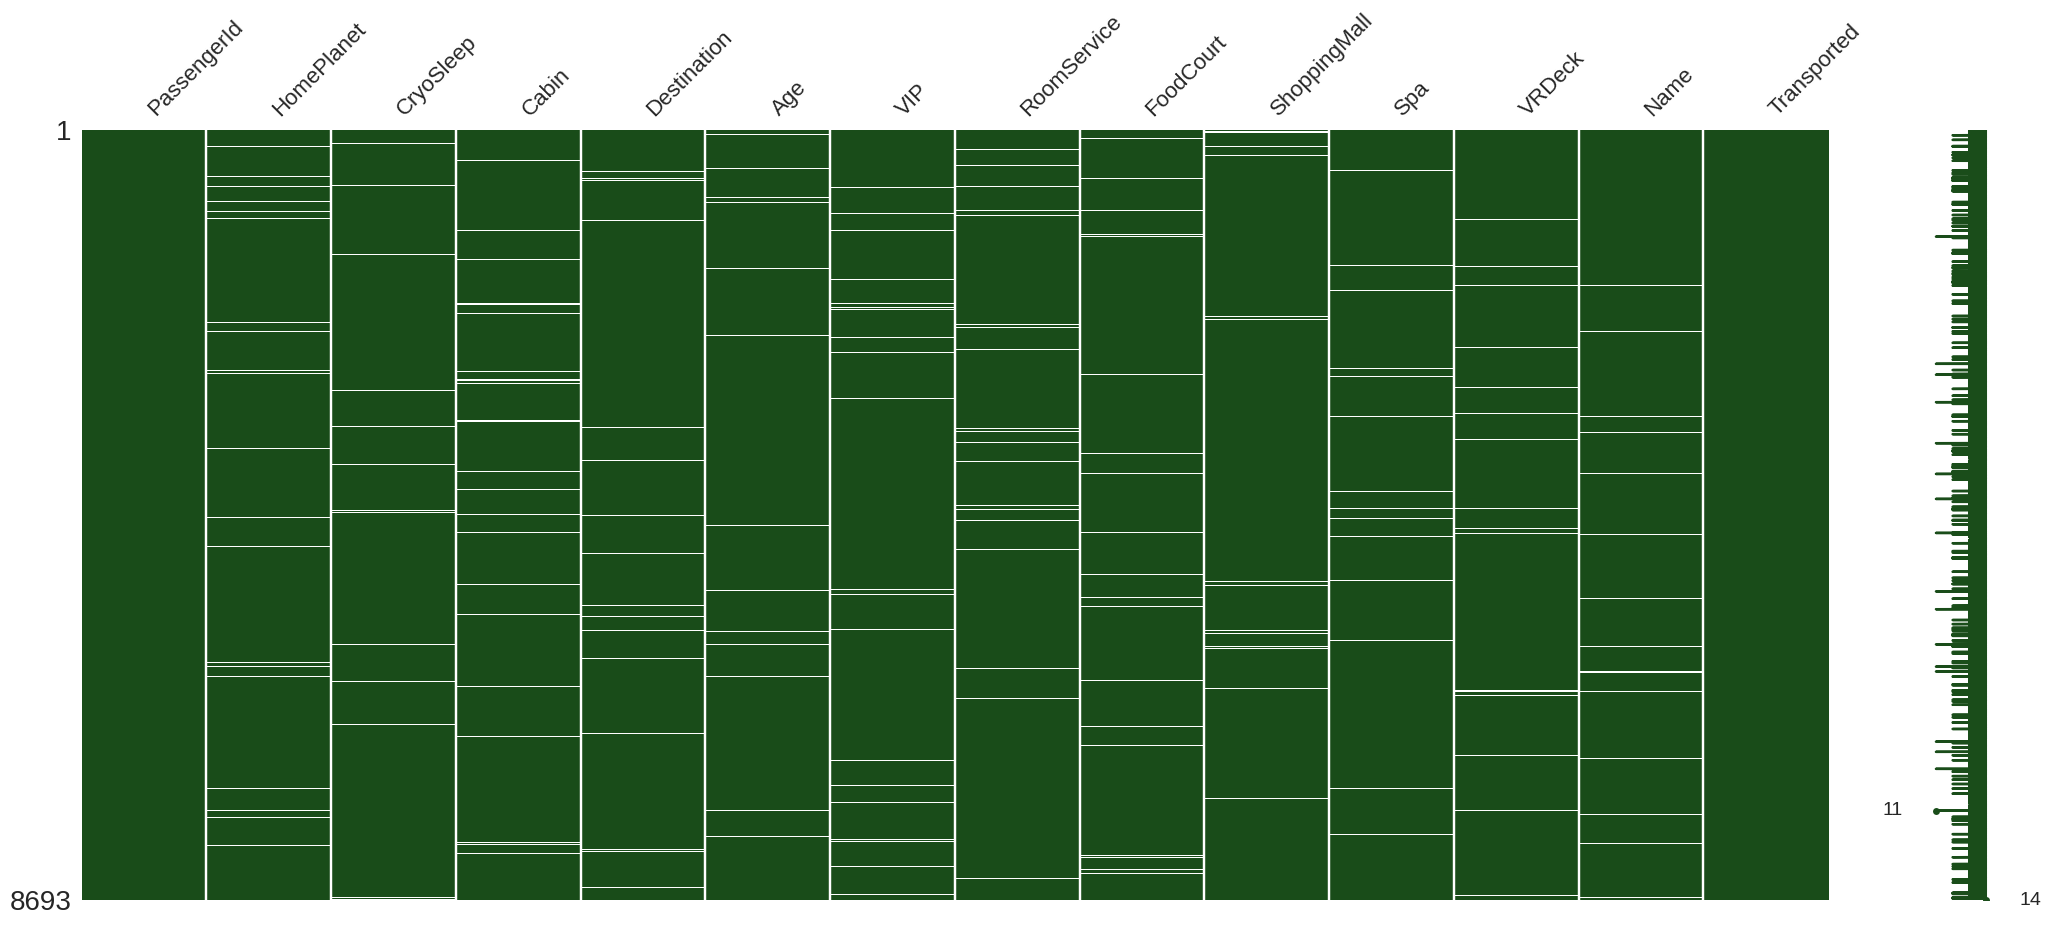

In [4]:
msno.matrix(train,color=(0.1,0.3,0.1))
plt.show()

<AxesSubplot: >

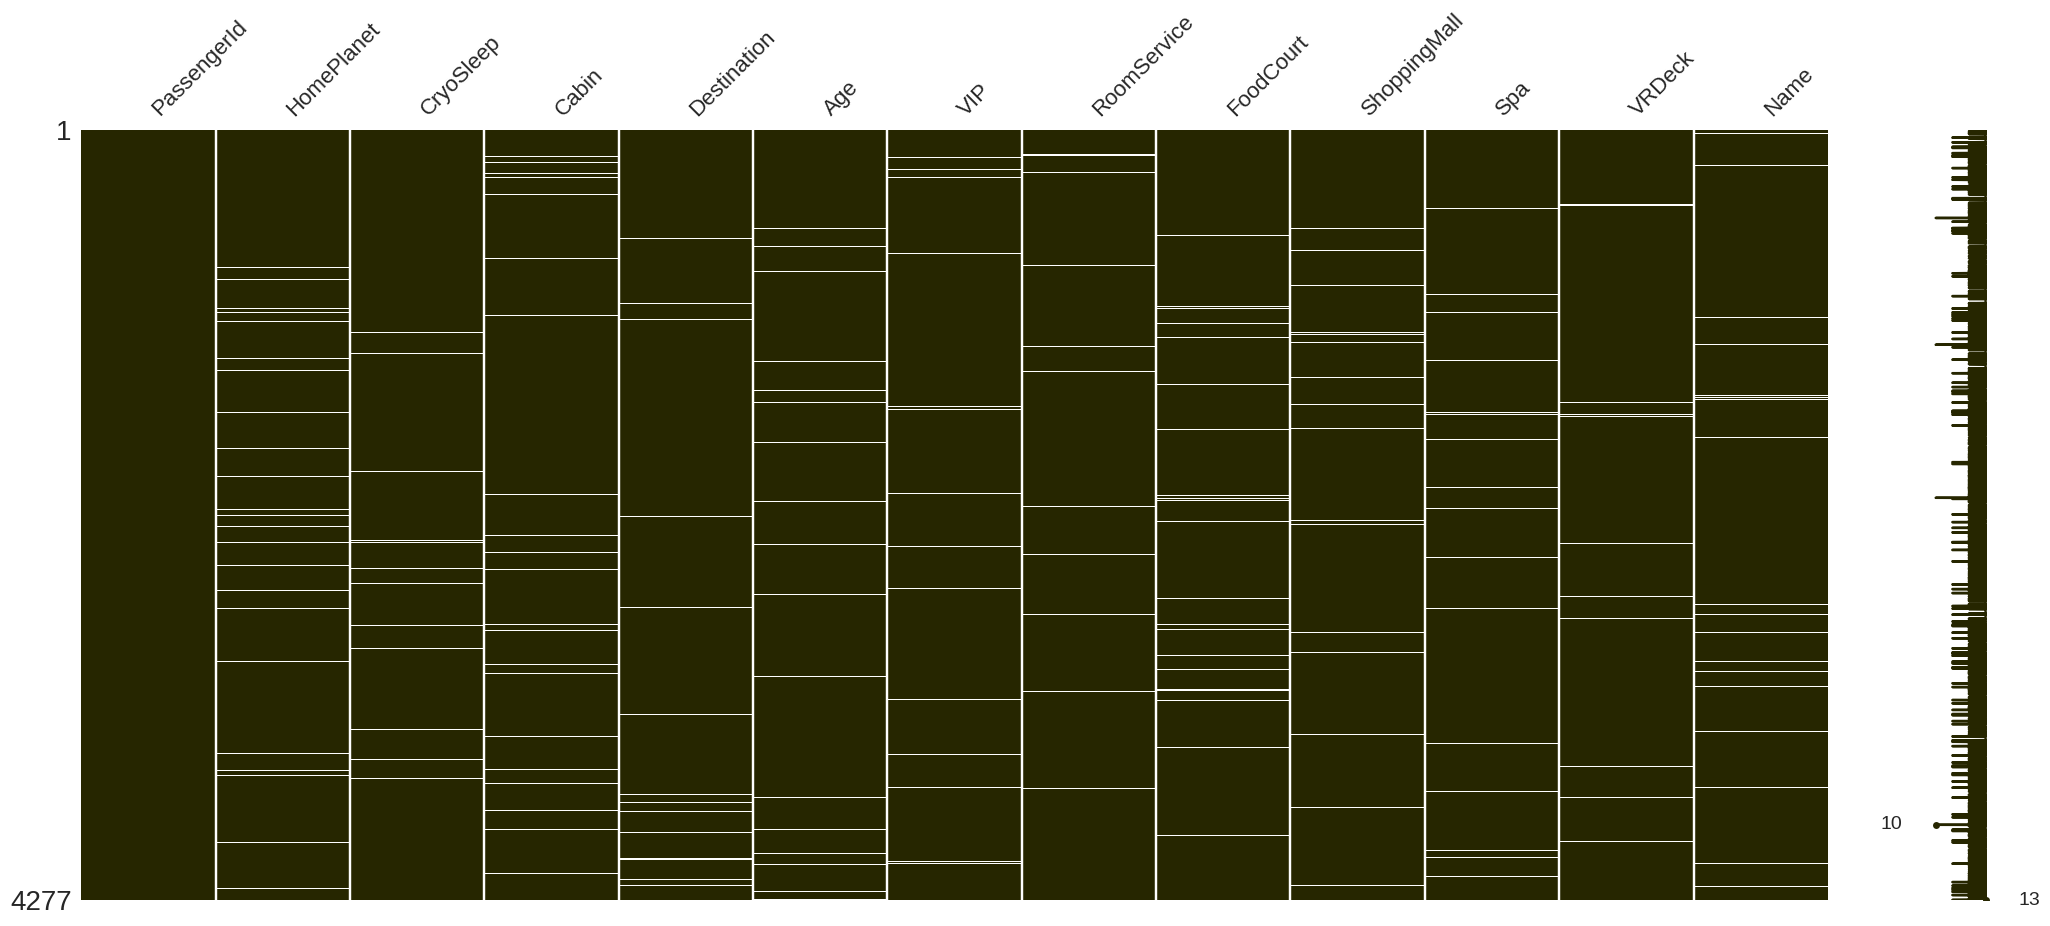

In [5]:
msno.matrix(test,color=(0.15,0.15,0))

## Target Analysis

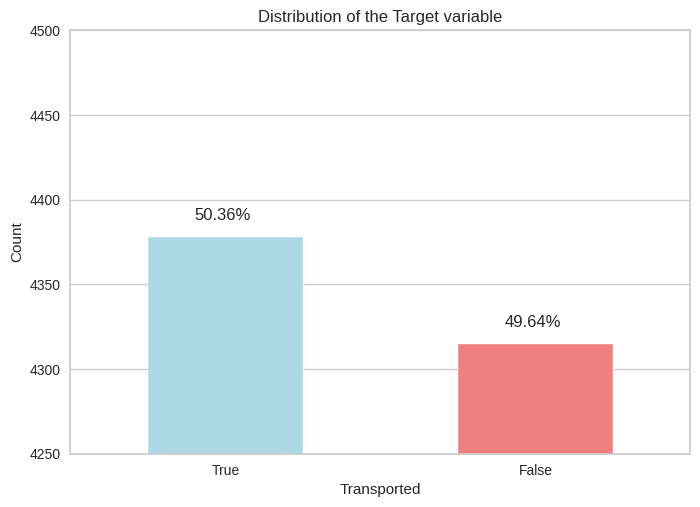

In [30]:
ax = train['Transported'].value_counts().plot(kind='bar', title="Distribution of the Target variable", fontsize=10,color=["lightblue", "lightcoral"], ylabel="Count",edgecolor=None)
ax.set_ylim([4250, 4500])
for i in range(len(train['Transported'].value_counts())):
    plt.text(i-0.1,train['Transported'].value_counts()[i]+10,f"{(train['Transported'].value_counts()[i]/len(train))*100:.2f}%")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.yaxis.grid(True)
ax.xaxis.grid(False)


In [31]:
train['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

## Numerical Feature Analysis

### Train and Test Data Distributions

In [45]:
numerics=['int16','int32','int64','float16','float32','float64']
num_cols=train.select_dtypes(include=numerics).columns.tolist()

def make_plot_hist(df_train,df_test,num_cols):

    fig,axes=plt.subplots(len(num_cols),2,figsize=(8,18))
    
    for i,ax in enumerate(axes.flat):
        

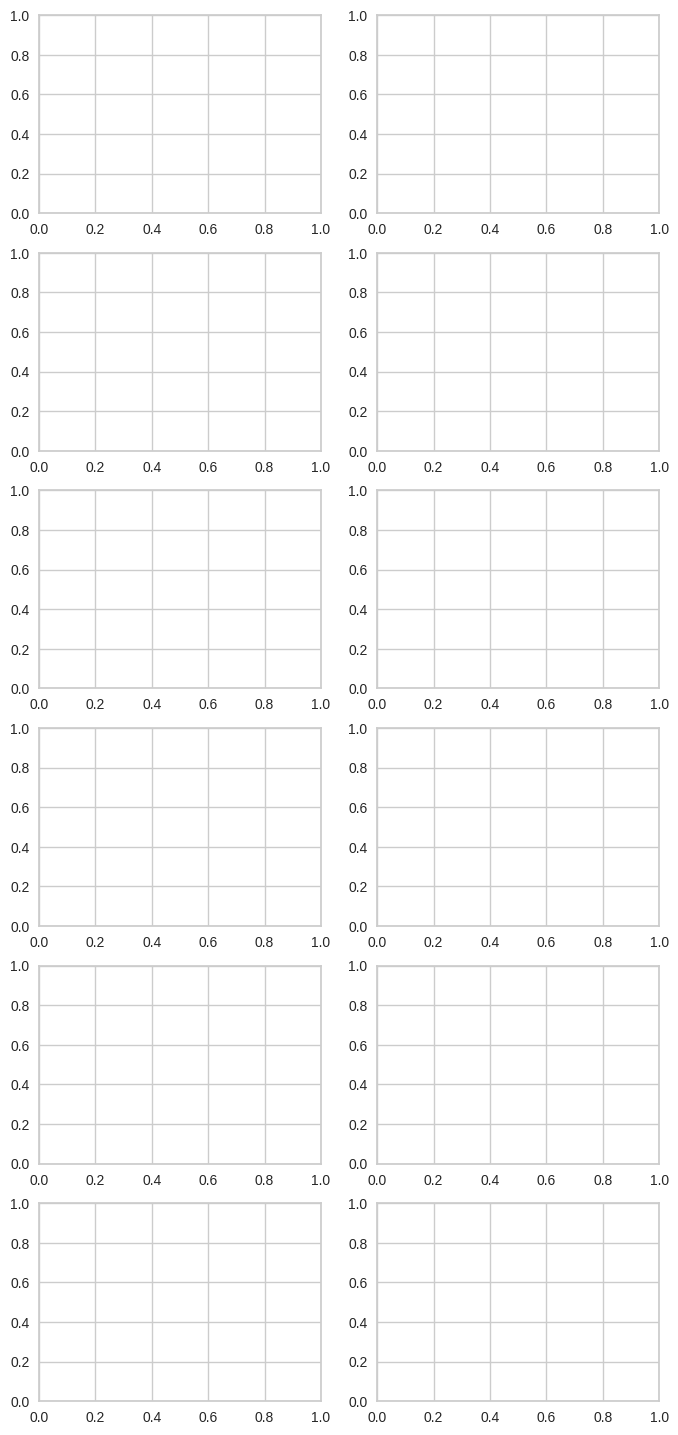

In [46]:
make_plot_hist(train,test,num_cols)